# Solve utility-scale quantum optimization problems

*Estimated QPU usage: 8 minutes (tested on IBM Sherbrooke)*

This tutorial demonstrates how to implement the **Quantum Approximate Optimization Algorithm (QAOA)** – a hybrid (quantum-classical) iterative method – within the context of Qiskit patterns. You will first solve the **Maximum-Cut** (or **Max-Cut**) problem for a small graph and then learn how to execute it at utility scale. All the hardware executions in the notebook should run within the time limit for the freely-accessible Open Plan.

The Max-Cut problem is an optimization problem that is hard to solve (more specifically, it is an *NP-hard* problem) with a number of different applications in clustering, network science, and statistical physics. This tutorial considers a graph of nodes connected by vertices, and aims to partition it into separate graphs such that they are both as large as possible. Put another way, the goal of this problem is to partition the nodes of a graph into two sets such that the number of edges traversed by this cut is maximized.

![Illustration of a max-cut problem](https://learning-api.quantum.ibm.com/assets/0de75f52-4873-4b5a-a0e9-a351dc48c910)


## Requirements

Before starting this tutorial, be sure you have the following installed:

* Qiskit SDK v1.0 or later, with visualization support ( `pip install 'qiskit[visualization]'` )
* Qiskit Runtime 0.22 or later (`pip install qiskit-ibm-runtime`)
* Rustworkx graph library (`pip install rustworkx`)


## Part 1: Small-scale QAOA

The first part of this tutorial uses a small-scale Max-Cut problem to illustrate the steps to solve an optimization problem using a quantum computer.

To give some context before mapping this problem to a quantum algorithm, you can better understand how the Max-Cut problem becomes a classical combinatorial optimization problem by first considering the minimization of a function $f(x)$

$$
\min_{x\in \{0, 1\}^n}f(x),
$$

where the input $x$ is a vector whose components correspond to each node of a graph.  Then, constrain each of these components to be either $0$ or $1$ (which represent being included or not included in the cut). This small-scale example case uses a graph with $n=5$ nodes.

You could write a function of a pair of nodes $i,j$ which indicates whether the corresponding edge $(i,j)$ is in the cut. For example, the function $x_i + x_j - 2 x_i x_j$ is 1 only if one of either $x_i$ or $x_j$ are 1 (which means that the edge is in the cut) and zero otherwise. The problem of maximizing the edges in the cut can be formulated as

$$
\max_{x\in \{0, 1\}^n} \sum_{(i,j)} x_i + x_j - 2 x_i x_j,
$$

which can be rewritten as a minimization of the form

$$
\min_{x\in \{0, 1\}^n} \sum_{(i,j)}  2 x_i x_j - x_i - x_j.
$$

The minimum of $f(x)$ in this case is when the number of edges traversed by the cut is maximal. As you can see, there is nothing relating to quantum computing yet. You need to reformulate this problem into something that a quantum computer can understand.


Initialize your problem by creating a graph with $n=5$ nodes.


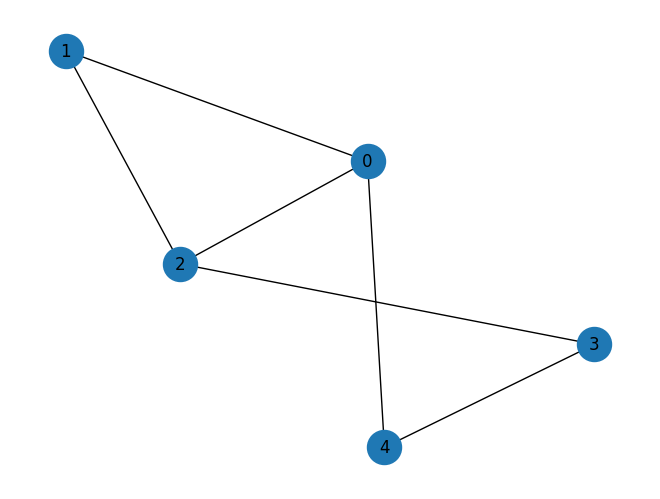

In [1]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np

n = 5

graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
edge_list = [(0, 1, 1.0), (0, 2, 1.0), (0, 4, 1.0), (1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0)]
graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

### Step 1. Map classical inputs to a quantum problem

The first step of the pattern is to map the classical problem (graph) into quantum **circuits** and **operators**. To do this, there are three main steps to take:

1. Utilize a series of mathematical reformulations, to represent this problem using the Quadratic Unconstrained Binary Optimization (QUBO) problems notation.
2. Rewrite the optimization problem as a Hamiltonian for which the ground state corresponds to the solution which minimizes the cost function.
3. Create a quantum circuit which will prepare the ground state of this Hamiltonian via a process similar to quantum annealing.

**Note:** In the QAOA methodology, you ultimately want to have an operator (**Hamiltonian**) that represents the **cost function** of our hybrid algorithm, as well as a parametrized circuit (**Ansatz**) that represents quantum states with candidate solutions to the problem. You can sample from these candidate states and then evaluate them using the cost function.

#### Graph → optimization problem

The first step of the mapping is a notation change, The following expresses the problem in QUBO notation:

$$
\min_{x\in \{0, 1\}^n}x^T Q x,
$$

where $Q$ is a $n\times n$ matrix of real numbers, $n$ corresponds to the number of nodes in your graph, $x$ is the vector of binary variables introduced above, and $x^T$ indicates the transpose of the vector $x$.

```
Maximize
 -2*x_0*x_1 - 2*x_0*x_2 - 2*x_0*x_4 - 2*x_1*x_2 - 2*x_2*x_3 - 2*x_3*x_4 + 3*x_0
 + 2*x_1 + 3*x_2 + 2*x_3 + 2*x_4

Subject to
  No constraints

  Binary variables (5)
    x_0 x_1 x_2 x_3 x_4
```


### Optimization problem → Hamiltonian

You can then reformulate the QUBO problem as a **Hamiltonian** (here, a matrix that represents the energy of a system):

$$
H_C=\sum_{ij}Q_{ij}Z_iZ_j + \sum_i b_iZ_i.
$$

> **Reformulation steps from the QAOA problem to the Hamiltonian**

> To demonstrate how the QAOA problem can be rewritten in this way, first replace the binary variables $x_i$ to a new set of variables $z_i\in\{-1, 1\}$ via
>
> $$
> x_i = \frac{1-z_i}{2}.
> $$
>
> Here you can see that if $x_i$ is $0$, then $z_i$ must be $1$. When the $x_i$'s are substituted for the $z_i$'s in the optimization problem ($x^TQx$), an equivalent formulation can be obtained.
>
> $$
> x^TQx=\sum_{ij}Q_{ij}x_ix_j \\ =\frac{1}{4}\sum_{ij}Q_{ij}(1-z_i)(1-z_j) \\=\frac{1}{4}\sum_{ij}Q_{ij}z_iz_j-\frac{1}{4}\sum_{ij}(Q_{ij}+Q_{ji})z_i + \frac{n^2}{4}.
> $$
>
> Now if we define $b_i=-\sum_{j}(Q_{ij}+Q_{ji})$, remove the prefactor, and the constant $n^2$ term, we arrive at the two equivalent formulations of the same optimization problem.
>
> $$
> \min_{x\in\{0,1\}^n} x^TQx\Longleftrightarrow \min_{z\in\{-1,1\}^n}z^TQz + b^Tz
> $$
>
> Here, $b$ depends on $Q$. Note that to obtain $z^TQz + b^Tz$ we dropped the factor of 1/4 and a constant offset of $n^2$ which do not play a role in the optimization.
>
> Now, to obtain a quantum formulation of the problem, promote the $z_i$ variables to a Pauli $Z$ matrix, such as a $2\times 2$ matrix of the form
>
> $$
> Z_i = \begin{pmatrix}1 & 0 \\ 0 & -1\end{pmatrix}.
> $$
>
> When you substitute these matrices in the optimization problem above, you obtain the following Hamiltonian
>
> $$
> H_C=\sum_{ij}Q_{ij}Z_iZ_j + \sum_i b_iZ_i.
> $$
>
> *Also recall that the $Z$ matrices are embedded in the quantum computer's computational space, i.e., a Hilbert space of size $2^n\times 2^n$. Therefore, you should understand terms such as $Z_iZ_j$ as the tensor product $Z_i\otimes Z_j$ embedded in the $2^n\times 2^n$ Hilbert space. For example, in a problem with five decision variables the term $Z_1Z_3$ is understood to mean $I\otimes Z_3\otimes I\otimes Z_1\otimes I$ where $I$ is the $2\times 2$ identity matrix.*

This Hamiltonian is called the <b>cost function Hamiltonian</b>. It has the property that its ground state corresponds to the solution that <b>minimizes the cost function $f(x)$</b>.
Therefore, to solve your optimization problem you now need to prepare the ground state of $H_C$ (or a state with a high overlap with it) on the quantum computer. Then, sampling from this state will, with a high probability, yield the solution to $min~f(x)$.


In [2]:
from qiskit.quantum_info import SparsePauliOp
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.

    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        paulis = ["I"] * len(graph)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"

        weight = graph.get_edge_data(edge[0], edge[1])

        pauli_list.append(("".join(paulis)[::-1], weight))

    return pauli_list


max_cut_paulis = build_max_cut_paulis(graph)

cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


#### Hamiltonian → quantum circuit


The Hamiltonian $H_c$ contains the quantum definition of your problem. Now you can create a quantum circuit that will help *sample* good solutions from the quantum computer. The QAOA is inspired by quantum annealing and applies alternating layers of operators in the quantum circuit.

The general idea is to start in the ground state of a known system, $H^{\otimes n}|0\rangle$ above, and then steer the system into the ground state of the cost operator that you are interested in. This is done by applying the operators $\exp\{-i\gamma_k H_C\}$ and $\exp\{-i\beta_k H_m\}$ with angles $\gamma_1,...,\gamma_p$ and $\beta_1,...,\beta_p~$.

The quantum circuit that you generate is **parametrized** by $\gamma_i$ and $\beta_i$, so you can try out different values of $\gamma_i$ and $\beta_i$ and sample from the resulting state.

![Circuit diagram with QAOA layers](https://learning-api.quantum.ibm.com/assets/29a70f21-b453-4df7-b726-19468e5b1f51)

In this case, you will try an example with one QAOA layer that contains two parameters: $\gamma_1$ and $\beta_1$.


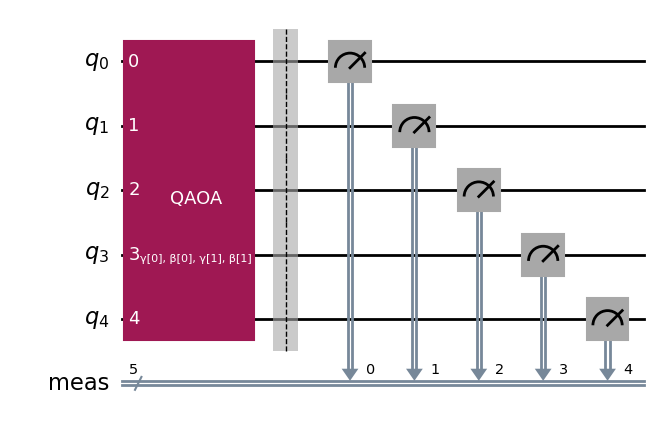

In [3]:
from qiskit.circuit.library import QAOAAnsatz

circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=2)
circuit.measure_all()

circuit.draw('mpl')

In [4]:
circuit.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1])])

### Step 2. Optimize circuits for quantum hardware execution


The circuit above contains a series of abstractions useful to think about quantum algorithms, but not possible to run on the hardware. To be able to run on a QPU, the circuit needs to undergo a series of operations that make up the **transpilation** or **circuit optimization** step of the pattern.

The Qiskit library offers a series of **transpilation passes** that cater to a wide range of circuit transformations. You need to make sure that your circuit is **optimized** for your purpose.

Transpilation may involves several steps, such as:

* **Initial mapping** of the qubits in the circuit (such as decision variables) to physical qubits on the device.
* **Unrolling** of the instructions in the quantum circuit to the hardware-native instructions that the backend understands.
* **Routing** of any qubits in the circuit that interact to physical qubits that are adjacent with one another.
* **Error suppression** by adding single-qubit gates to suppress noise with dynamical decoupling.

More information about transpilation is available in our [documentation](https://docs.quantum.ibm.com/transpile).

The following code transforms and optimizes the abstract circuit into a format that is ready for execution on one of devices accessible through the cloud using the **Qiskit IBM Runtime service**.


<IBMBackend('ibm_kyiv')>


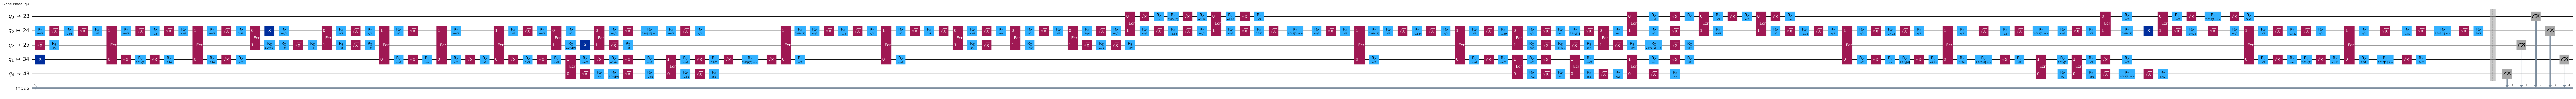

In [5]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager


# QiskitRuntimeService.save_account(channel="ibm_quantum", token="TOKEN", overwrite=True, set_as_default=True)
service = QiskitRuntimeService(channel='ibm_quantum')
backend = service.least_busy(min_num_qubits=127)
print(backend)

# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3,
                                    backend=backend)

candidate_circuit = pm.run(circuit)
candidate_circuit.draw('mpl', fold=False, idle_wires=False)

### Step 3. Execute using Qiskit primitives


In the QAOA workflow, the optimal QAOA parameters are found in an iterative optimization loop, which runs a series of circuit evaluations and uses a classical optimizer to find the optimal $\beta_k$ and $\gamma_k$ parameters. This execution loop is executed via the following steps:

1. Define the initial parameters
2. Instantiate a new `Session` containing the optimization loop and the primitive used to sample the circuit
3. Once an optimal set of parameters is found, execute the circuit a final time to obtain a final distribution which will be used in the post-process step.


#### Define circuit with initial parameters

We start with arbitrary chosen parameters.


In [6]:
initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta, initial_gamma, initial_beta]

#### Define backend and execution primitive

Use the **Qiskit Runtime primitives** to interact with IBM® backends. The two primitives are Sampler and Estimator, and the choice of primitive depends on what type of measurement you want to run on the quantum computer. For the minimization of $H_c$, use the Estimator since the measurement of the cost function is simply the expectation value of $\langle H_c \rangle$.


#### Run

The primitives offer a variety of [execution modes](https://docs.quantum.ibm.com/run/execution-modes) to schedule workloads on quantum devices, and a QAOA workflow runs iteratively in a session.

![Illustration showing the behavior of Single job, Batch, and Session runtime modes.](https://learning-api.quantum.ibm.com/assets/73e400b1-e5a9-4ee8-9842-3e2bbfbef3f5)

You can plug the sampler-based cost function into the SciPy minimizing routine to find the optimal parameters.


In [ ]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)


    return cost

In [24]:
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from scipy.optimize import minimize

objective_func_vals = [] # Global variable
with Session(backend=backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1000

    # Set simple error suppression/mitigation options
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"
    # estimator.options.twirling.enable_gates = True
    # estimator.options.twirling.num_randomizations = "auto"

    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit, cost_hamiltonian, estimator),
        method="COBYLA",
        tol=5e-1,
    )
    print(session.details())
    print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.1356392865479266
       x: [ 4.510e+00  3.300e+00  3.536e+00  1.461e+00]
    nfev: 14
   maxcv: 0.0


The optimizer was able to reduce the cost and find better parameters for the circuit.


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

Once you have found the optimal parameters for the circuit, you can assign these parameters and sample the final distribution obtained with the optimized parameters. Here is where the *Sampler* primitive should be used since it is the probability distribution of bitstring measurements which correspond to the optimal cut of the graph.

**Note:** This means preparing a quantum state $\psi$ in the computer and then measuring it. A measurement will collapse the state into a single computational basis state - for example, `010101110000...` - which corresponds to a candidate solution $x$ to our initial optimization problem ($\max f(x)$ or $\min f(x)$ depending on the task).


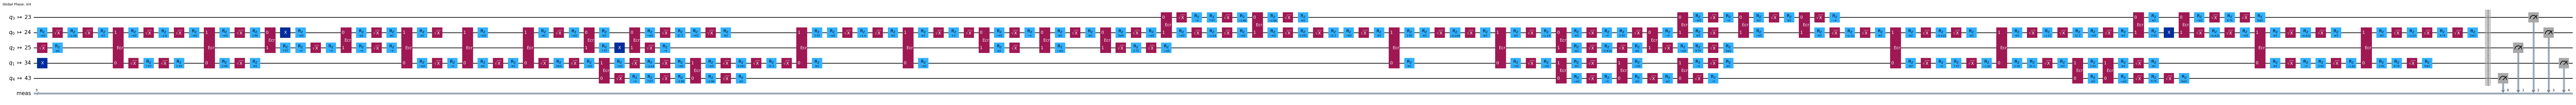

In [25]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw('mpl', fold=False, idle_wires=False)

In [26]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000

# Set simple error suppression/mitigation options
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"

pub= (optimized_circuit, )
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_int)

{13: 0.0433, 7: 0.0205, 4: 0.0227, 26: 0.0575, 11: 0.0587, 5: 0.0585, 14: 0.0302, 9: 0.0578, 28: 0.0297, 19: 0.0256, 22: 0.0501, 8: 0.0157, 10: 0.0415, 30: 0.0224, 1: 0.0259, 16: 0.0181, 23: 0.016, 20: 0.0481, 29: 0.016, 2: 0.0188, 25: 0.0314, 21: 0.0341, 3: 0.0448, 12: 0.0269, 24: 0.0203, 0: 0.0164, 18: 0.0348, 6: 0.0365, 15: 0.0156, 31: 0.0164, 27: 0.0191, 17: 0.0266}


### Step 4. Post-process, return result in classical format

The post-processing step interprets the sampling output to return a solution for your original problem. In this case, you are interested in the bitstring with the highest probability as this determines the optimal cut. The symmetries in the problem allow for four possible solutions, and the sampling process will return one of them with a slightly higher probability, but you can see in the plotted distribution below that four of the bitstrings are distictively more likely than the rest.


In [27]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, len(graph))
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [1, 1, 0, 1, 0]


C:\Users\yasin\AppData\Local\Temp\ipykernel_22480\848787215.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.get_children()[int(p)].set_color("tab:purple")


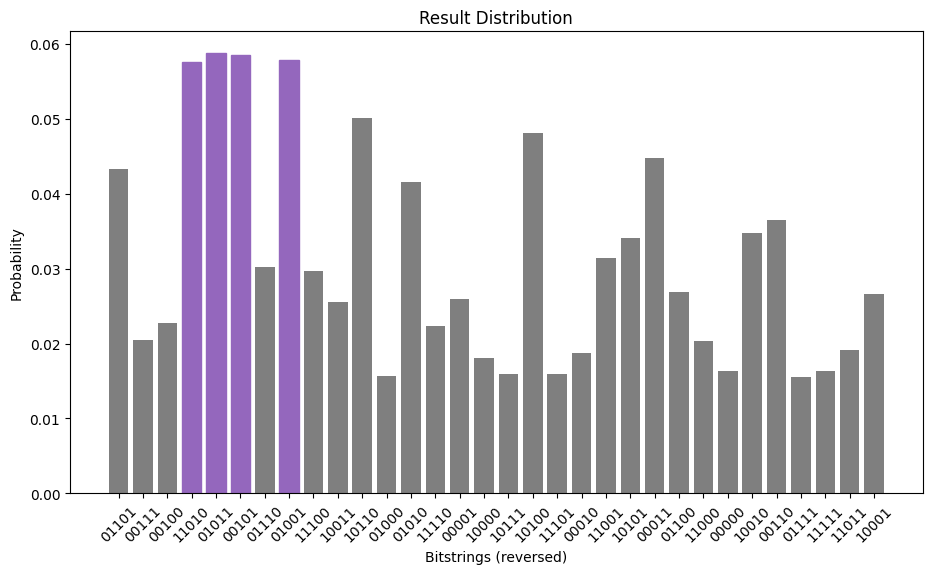

In [28]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p)].set_color("tab:purple")
plt.show()

#### Visualize best cut

From the optimal bit string, you can then visualize this cut on the original graph.


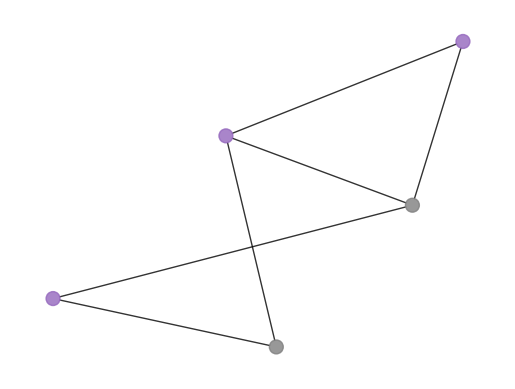

In [29]:
# auxiliary function to plot graphs
def plot_result(G, x):
    colors = ["tab:grey" if i == 0 else "tab:purple" for i in x]
    pos, default_axes = rx.spring_layout(G), plt.axes(frameon=True)
    rx.visualization.mpl_draw(G, node_color=colors, node_size=100, alpha=0.8, pos=pos)


plot_result(graph, most_likely_bitstring)

And calculate the value of the cut


In [30]:
from typing import Sequence
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    assert len(x) == len(list(graph.nodes())), "The length of x must coincide with the number of nodes in the graph."
    return sum(x[u] * (1 - x[v]) + x[v] * (1 - x[u]) for u, v in list(graph.edge_list()))


cut_value= evaluate_sample(most_likely_bitstring, graph)
print('The value of the cut is:', cut_value)

The value of the cut is: 5


## Part 2: scale it up!

You have access to many devices with over 100 qubits on IBM Quantum Platform. Select one on which to solve Max-Cut on a 100-node weighted graph. This is a "utility-scale" problem. The steps to build the workflow are followed the same as above, but with a much larger graph.


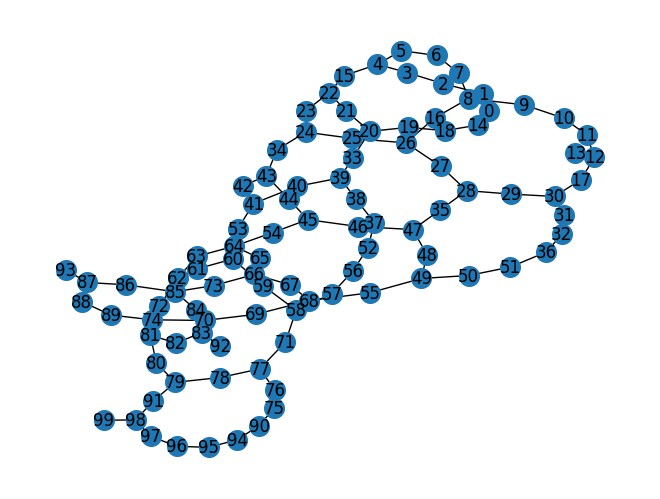

In [31]:
n = 100  # Number of nodes in graph
graph_100 = rx.PyGraph()
graph_100.add_nodes_from(np.arange(0, n, 1))
elist = []
for edge in backend.coupling_map:
    if edge[0] < n and edge[1] < n:
        elist.append((edge[0], edge[1], 1.0))
graph_100.add_edges_from(elist)
draw_graph(graph_100, node_size=200, with_labels=True, width=1)

### Step 1. Map classical inputs to a quantum problem


#### Graph → Hamiltonian

First, convert the graph you want to solve directly into a Hamiltonian that is suited for QAOA.


In [32]:
max_cut_paulis_100 = build_max_cut_paulis(graph_100)

cost_hamiltonian_100 = SparsePauliOp.from_list(max_cut_paulis_100)
print("Cost Function Hamiltonian:", cost_hamiltonian_100)

Cost Function Hamiltonian: SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZI', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIZIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIII', 'IIIIIIIIIIIIIIIIIIIII

#### Hamiltonian → quantum circuit


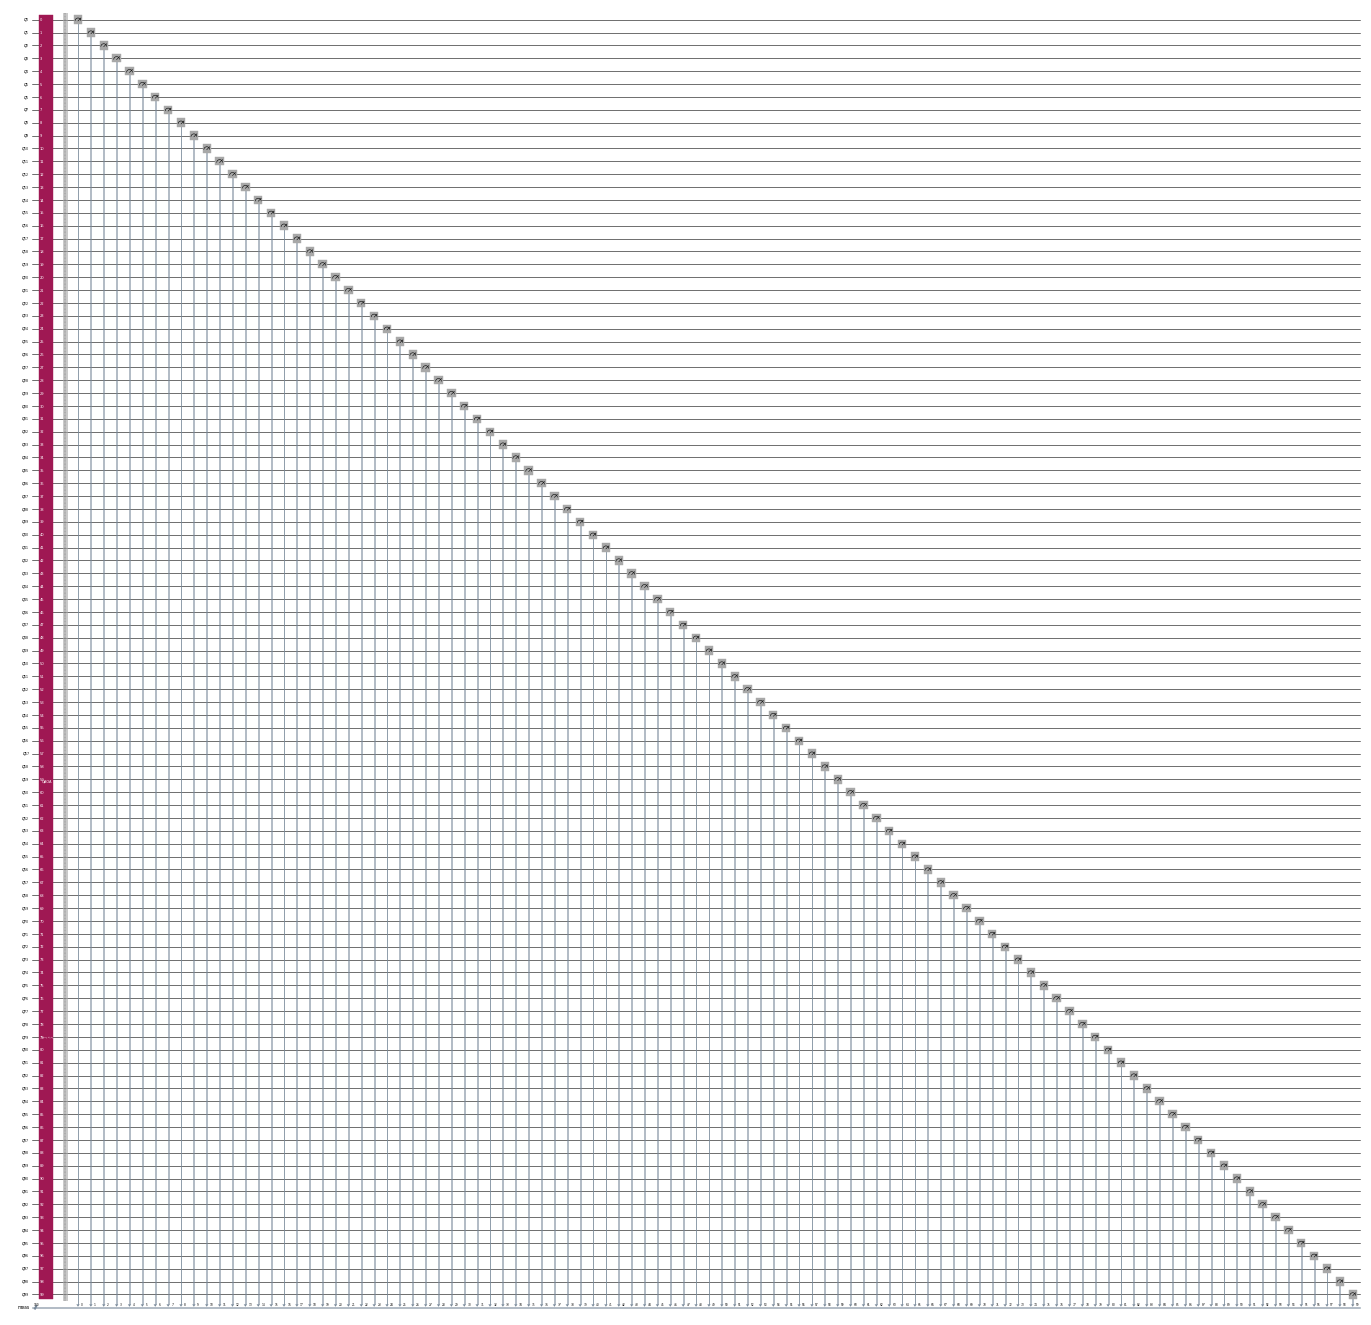

In [33]:
from qiskit.circuit.library import QAOAAnsatz

circuit_100 = QAOAAnsatz(cost_operator=cost_hamiltonian_100, reps=1)
circuit_100.measure_all()

circuit_100.draw('mpl', fold=False, scale=0.2, idle_wires=False)

### Step 2. Optimize problem for quantum execution

To scale the circuit optimization step to utility-scale problems, you can take advantage of the high performance transpilation strategies introduced in Qiskit SDK v1.0. Other tools include the new transpiler service with [AI enhanced transpiler passes](https://docs.quantum.ibm.com/transpile/ai-transpiler-passes).


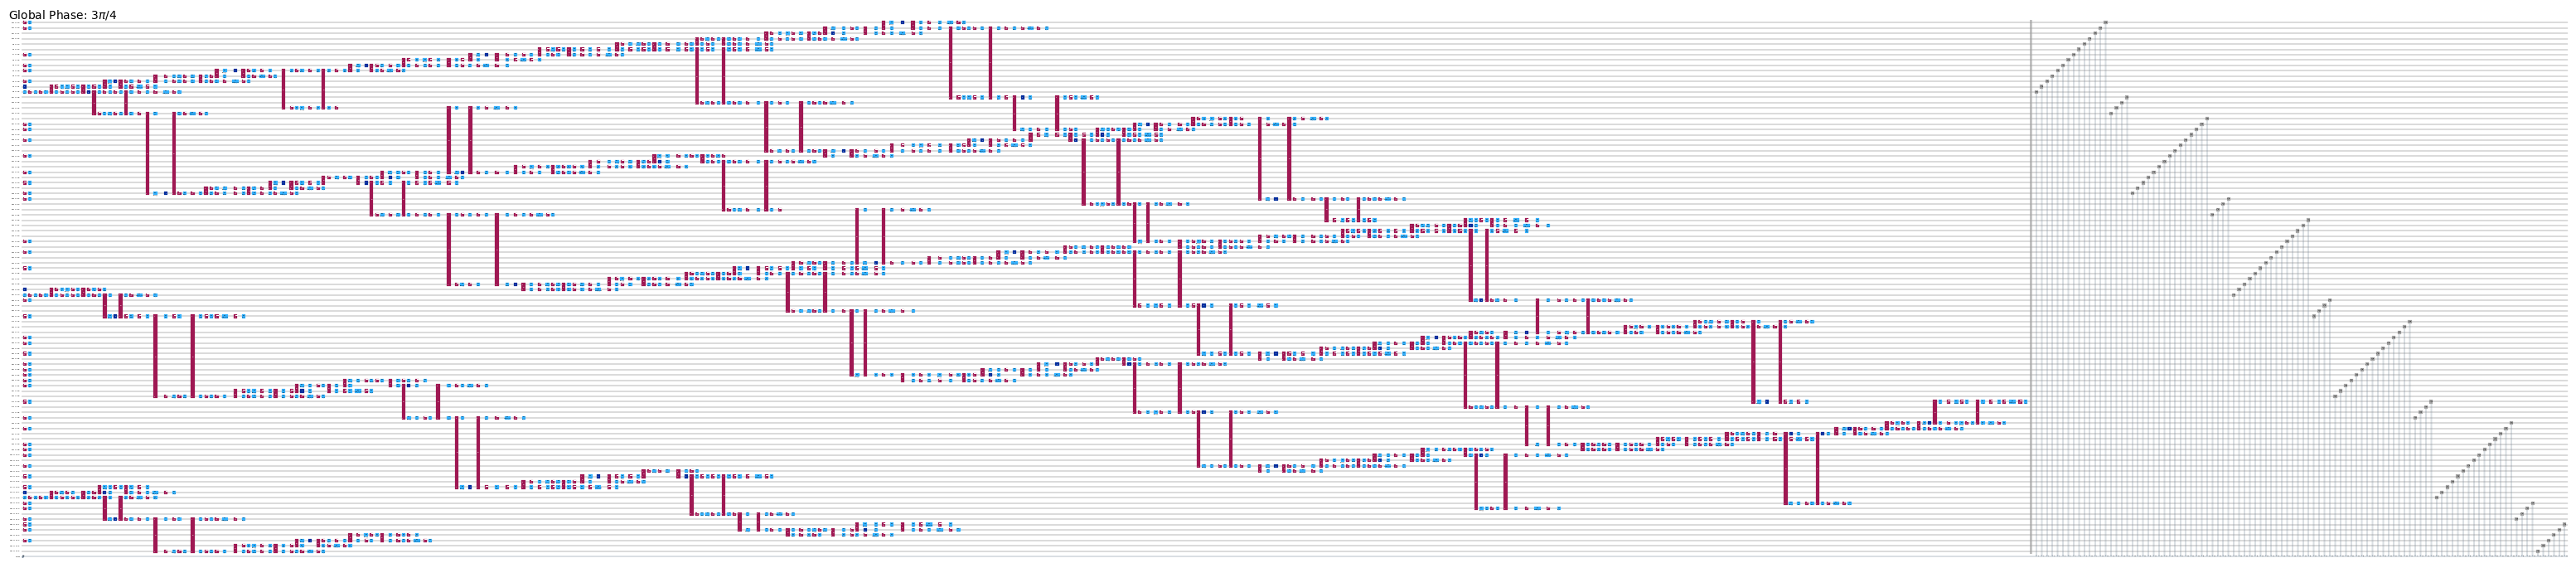

In [34]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(optimization_level=3,
                                    backend=backend)

candidate_circuit_100 = pm.run(circuit_100)
candidate_circuit_100.draw('mpl', fold=False, scale=0.1, idle_wires=False)

### Step 3. Execute using Qiskit primitives

To run QAOA, you must know the optimal parameters $\gamma_k$ and $\beta_k$ to put in the variational circuit. Optimize these parameters by running an optimization loop on the device. The cell submits jobs until the cost function value has converged and the optimal parameters for $\gamma_k$ and $\beta_k$ are determined.


#### Find candidate solution by running the optimization on the device


First, run the optimization loop for the circuit parameters on a device.


In [37]:
initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta]

objective_func_vals = [] # Global variable
with Session(backend=backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=session)

    estimator.options.default_shots = 1000

    # Set simple error suppression/mitigation options
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"
    # estimator.options.twirling.enable_gates = True
    # estimator.options.twirling.num_randomizations = "auto"

    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit_100, cost_hamiltonian_100, estimator),
        method="COBYLA",
    )
    print(result)

IBMRuntimeError: 'Failed to run program: \'400 Client Error: Bad Request for url: https://api.quantum.ibm.com/runtime/jobs. {"errors":[{"code":1217,"message":"Session has been closed.","solution":"Reduce time between submitting subsequent jobs in a session.","more_info":"https://docs.quantum-computing.ibm.com/errors"}]}\''

Once the optimal parameters from running QAOA on the device have been found, assign the parameters to the circuit


In [ ]:
optimized_circuit_100 = candidate_circuit_100.assign_parameters(result.x)
optimized_circuit_100.draw('mpl', fold=False, idle_wires=False)

Finally, execute the circuit with the optimal parameters to sample from the corresponding distribution.


In [ ]:
# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000

# Set simple error suppression/mitigation options
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"


pub= (optimized_circuit_100, )
job = sampler.run([pub], shots=int(1e4))

counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_100_int = {key: val/shots for key, val in counts_int.items()}

### Step 4. Post-process, return result in classical format


Check that the cost minimized in the optimization loop has converged to a certain value. The code below uses the parameters corresponding to the minimum value of the cost.


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

Given that the likelihood of each solution is low, extract the solution that corresponds to the lowest cost.


In [ ]:
_PARITY = np.array([-1 if bin(i).count("1") % 2 else 1 for i in range(256)], dtype=np.complex128)


def evaluate_sparse_pauli(state: int, observable: SparsePauliOp) -> complex:
    """Utility for the evaluation of the expectation value of a measured state."""
    packed_uint8 = np.packbits(observable.paulis.z, axis=1, bitorder="little")
    state_bytes = np.frombuffer(state.to_bytes(packed_uint8.shape[1], "little"), dtype=np.uint8)
    reduced = np.bitwise_xor.reduce(packed_uint8 & state_bytes, axis=1)
    return np.sum(observable.coeffs * _PARITY[reduced])

def best_solution(samples, hamiltonian):
    """Find solution with lowest cost"""
    min_cost = 1000
    min_sol = None
    for bit_str in samples.keys():
        # Qiskit use little endian hence the [::-1]
        candidate_sol = int(bit_str)
        # fval = qp.objective.evaluate(candidate_sol)
        fval = evaluate_sparse_pauli(candidate_sol, hamiltonian).real
        if fval <= min_cost:
            min_sol = candidate_sol

    return min_sol

best_sol_100 = best_solution(final_distribution_100_int, cost_hamiltonian_100)
best_sol_bitstring_100 = to_bitstring(int(best_sol_100), len(graph_100))
best_sol_bitstring_100.reverse()

print("Result bitstring:", best_sol_bitstring_100)

Next, visualize the cut. Nodes of the same color belong to the same group.


In [ ]:
plot_result(graph_100, best_sol_bitstring_100)

And calculate the the value of the cut


In [ ]:
cut_value_100= evaluate_sample(best_sol_bitstring_100, graph_100)
print('The value of the cut is:', cut_value_100)

Now you need to compute the objective value of each sample that you measured on the quantum computer. The sample with the lowest objective value is the solution returned by the quantum computer.


In [ ]:
from collections import defaultdict
import matplotlib.pyplot as plt

# auxiliary function to help plot cumulative distribution functions
def _plot_cdf(objective_values: dict, ax, color):
    x_vals = sorted(objective_values.keys(), reverse=True)
    y_vals = np.cumsum([objective_values[x] for x in x_vals])
    ax.plot(x_vals, y_vals, color=color)


def plot_cdf(dist, ax, title):
    _plot_cdf(dist, ax, "C1",)
    ax.vlines(min(list(dist.keys())), 0, 1, "C1", linestyle="--")

    ax.set_title(title)
    ax.set_xlabel("Objective function value")
    ax.set_ylabel("Cumulative distribution function")
    ax.grid(alpha=0.3)

# auxiliary function to convert bit-strings to objective values
def samples_to_objective_values(samples, hamiltonian):
    """Convert the samples to values of the objective function."""

    objective_values = defaultdict(float)
    for bit_str, prob in samples.items():
        candidate_sol = int(bit_str)
        fval = evaluate_sparse_pauli(candidate_sol, hamiltonian).real
        objective_values[fval] += prob

    return objective_values

In [ ]:
result_dist = samples_to_objective_values(final_distribution_100_int, cost_hamiltonian_100)

Finally, you can plot the cumulative distribution function to visualize how each sample contributes to the total probability distribution and the corresponding objective value. The horizontal spread shows the range of objective values of the samples in the final distribution. Ideally, you would see that the cumulative distribution function has "jumps" at the lower end of the objective function value axis. This would mean that few solutions with low cost have high probability of being sampled. A smooth, wide curve indicates that each sample is similarly likely, and they can have very different objective values, low or high.


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plot_cdf(result_dist, ax, "Eagle device")

## Conclusion

This tutorial demonstrated how to solve an optimization problem with a quantum computer using the Qiskit patterns framework. The demonstration included a utility-scale example, with circuit sizes that cannot be exactly simulated classically. Currently, quantum computers do not outperform classical computers for combinatorial optimization because of noise. However, the hardware is steadily improving, and new algorithms for quantum computers are continually being developed. Indeed, much of the research working on quantum heuristics for combinatorial optimization is tested with classical simulations that only allow for a small number of qubits, typically around 20 qubits. Now, with larger qubit counts and devices with less noise, researchers will be able to start benchmarking these quantum heuristics at large problem sizes on quantum hardware.
